<a href="https://colab.research.google.com/github/marcinwolter/tarcza/blob/main/tarcza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Rekonstrukcja współrzędnych punktu trafienia w tarczę**
*Marcin Wolter*

*29.12.2024*

Tarcza ma promień *radius*, cztery mikrofony rozmieszczone są w odległości *R_mic* od środka tarczy. Generowane jest *num_points* trafień w tarczę. Dodany jest błąd pomiaru czasu.

Rekonstrukcja punktu trafienia przeprowadzana jest na dwa sposoby:
* algebraiczny, rozwiązanie układu równań za pomocą *scipy.optimize.fsolve*. Uzyskujemy cztery rozwiązania, wyciągamy z nich średnią.
UWAGA! Zamiast używać numerycznego rozwiązania równań *fsolve* należy rozwiązać je algebraicznie (da się zrobić).
* za pomocą sieci neuronowej, która rekonstruuje punkt trafienia na podstawie czasów zarejestrowanych przez mikrofony.

In [1]:
# prompt: random points on a plane within the radius R

import random
import numpy as np
from scipy.optimize import fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle


# speed of sound
v_s = 34000 # cm/s


In [2]:
# algebraic calculation

def algebraic_calc(out_meas, R_mic):

  out_pred = np.zeros((len(out_meas),2))
  for i in range(len(out_meas)):

    t0 = out_meas[i]

    #Calculate three crossing points and take an average
    def equations(vars, R, d0, d1, d2, d3, i_drop):
      x, y, d = vars
      eq0 = (x - R)**2 + y**2 - (d0+d)**2
      eq1 = x**2 + (y + R)**2 - (d1+d)**2
      eq2 = (x + R)**2 + y**2 - (d2+d)**2
      eq3 = x**2 + (y - R)**2 - (d3+d)**2
      if i_drop == 0:
        return [eq1, eq2, eq3]
      elif i_drop == 1:
        return [eq0, eq2, eq3]
      elif i_drop == 2:
        return [eq0, eq1, eq3]
      return [eq0, eq1, eq2]

    # Calculate distances
    dd0 = v_s * t0

    # Initial guess for (x, y, d)
    initial_guess = (0, 0, 0)

    # Solve the system of equations
    x_out = np.zeros((len(t0),2))
    for k in range(len(t0)):
      x, y, d = fsolve(equations, initial_guess, args=(R_mic, dd0[0], dd0[1], dd0[2], dd0[3], k))
      x_out[k,0] = -y
      x_out[k,1] = x
    x_mean = np.mean(x_out, axis=0)

    out_pred[i,0] = x_mean[0]
    out_pred[i,1] = x_mean[1]

  return out_pred


In [3]:
def monte_carlo_circle(R, R_mic, time_error, num_points):
    """
    Points within a circle of radius R using Monte Carlo simulation.

    Args:
        R: The radius of the circle.
        num_points: The number of random points to generate.

    Returns:
        A tuple containing:
            - x, y of the true points
            - four times measured (one is zero)
            - rotation flag
    """
    # microphone positions
    xy_mic = np.array([[0, R_mic], [R_mic, 0], [0, -R_mic], [-R_mic,0]])
    time = np.zeros((4))

    out_true = np.zeros((num_points, 2))
    out_measured = np.zeros((num_points, 4))
    rot_flag = np.zeros((num_points))
    inside_circle = 0

    while inside_circle < num_points:
        x = random.uniform(-R, R)
        y = random.uniform(-R, R)
        distance2 = x*x + y*y
        if distance2 <= R*R:
          for i in range(4):
            time[i] = np.sqrt((xy_mic[i,0]-x)**2 + (xy_mic[i,1]-y)**2)/v_s
            # introduce error
            time[i] = max(0,time[i]+random.gauss(0,time_error))

          i_min = np.argmin(time)

          for k in range(4):
            out_measured[inside_circle, k] = time[k]-time[i_min]
          rot_flag[inside_circle] = i_min

          out_true[inside_circle, 0] = x
          out_true[inside_circle, 1] = y

          inside_circle += 1
          #print(f"point: {x, y, inside_circle}")



    return out_true, out_measured, rot_flag



In [4]:
# neural network regression out_measured -> out_true
def regression(out_measured, out_true):
    X_train, X_test, y_train, y_test = train_test_split(out_measured, out_true,
                                                    random_state=1)

    #see https://scikit-learn.org/1.6/modules/generated/sklearn.neural_network.MLPRegressor.html
    regr = MLPRegressor(hidden_layer_sizes=(30,30), activation='relu', solver='adam',
                        alpha=0.0001, batch_size='auto', learning_rate='adaptive',
                        learning_rate_init=0.001, random_state=33, tol=0.0001,
                        verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                        early_stopping=True, validation_fraction=0.2, n_iter_no_change=100,
                        max_iter = 10000)
    regr.fit(X_train, y_train)

    print("Regression score: ",regr.score(X_test, y_test))

    return regr


In [5]:
def plot_error(out_pred, out_true, text):

  fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

  min = np.min(out_pred[:,0] - out_true[:,0])
  max = np.max(out_pred[:,0] - out_true[:,0])
  rr = np.max([np.abs(min), np.abs(max)])

  # First histogram
  axs[0].hist(out_pred[:,0] - out_true[:,0], range = (-rr,rr), density=True, bins=30, edgecolor='black')
  axs[0].set_xlabel('Error X')
  axs[0].set_ylabel('Frequency')

  #Fit gaussian
  # Fit a Gaussian to the histogram data
  mu, std = norm.fit(out_pred[:,0] - out_true[:,0])


  # Plot the Gaussian fit
  x = np.linspace(-rr, rr, 100)
  p = norm.pdf(x, mu, std)
  axs[0].plot(x, p, 'k', linewidth=2)

  # Add title and labels
  axs[0].set_title(f'Histogram of X error {text}\nFit results: mu = {mu:.2f}, std = {std:.2f}')



  # Second histogram
  axs[1].hist(out_pred[:,1] - out_true[:,1], range = (-rr,rr), density=True, bins=30, edgecolor='black')
  axs[1].set_xlabel('Error Y')
  axs[1].set_ylabel('Frequency')

  #Fit gaussian
  # Fit a Gaussian to the histogram data
  mu, std = norm.fit(out_pred[:,1] - out_true[:,1])


  # Plot the Gaussian fit
  x = np.linspace(-rr, rr, 100)
  p = norm.pdf(x, mu, std)
  axs[1].plot(x, p, 'k', linewidth=2)

  # Add title and labels
  axs[1].set_title(f'Histogram of Y error {text}\nFit results: mu = {mu:.2f}, std = {std:.2f}')



  plt.tight_layout()
  plt.show()

In [6]:
# Example usage:
radius = 5.0  # Set the radius of the circle
num_points = 10000 # 10000  # Set the number of random points
R_mic = 7.
time_error = 0.000005 # 0.00001

out_true, out_meas, rot_flag = monte_carlo_circle(radius, R_mic, time_error, num_points)
#print(f"true: {out_true[0:4]}")
#print(f"meas: {out_meas[0:4]}")
#print(f"rot: {rot_flag[0:4]}")
#print(out_true.shape, out_meas.shape, rot_flag.shape)


In [7]:

# algebraic calculation
out_pred = algebraic_calc(out_meas, R_mic)

print("Algebraic calculation")
print("true: ")
print(out_true[0:4])
print("predicted:")
print(out_pred[0:4])
print("Algebraic calc score: ",sklearn.metrics.r2_score(out_true, out_pred))
print(" ")


Algebraic calculation
true: 
[[0.07391434 4.65202869]
 [0.81981004 4.76183214]
 [1.13614881 3.23270404]
 [3.27195778 0.94254568]]
predicted:
[[0.12375722 4.81326503]
 [0.98190563 4.99425094]
 [1.18413518 3.12805382]
 [3.17879681 0.79426061]]
Algebraic calc score:  0.9967433740771043
 


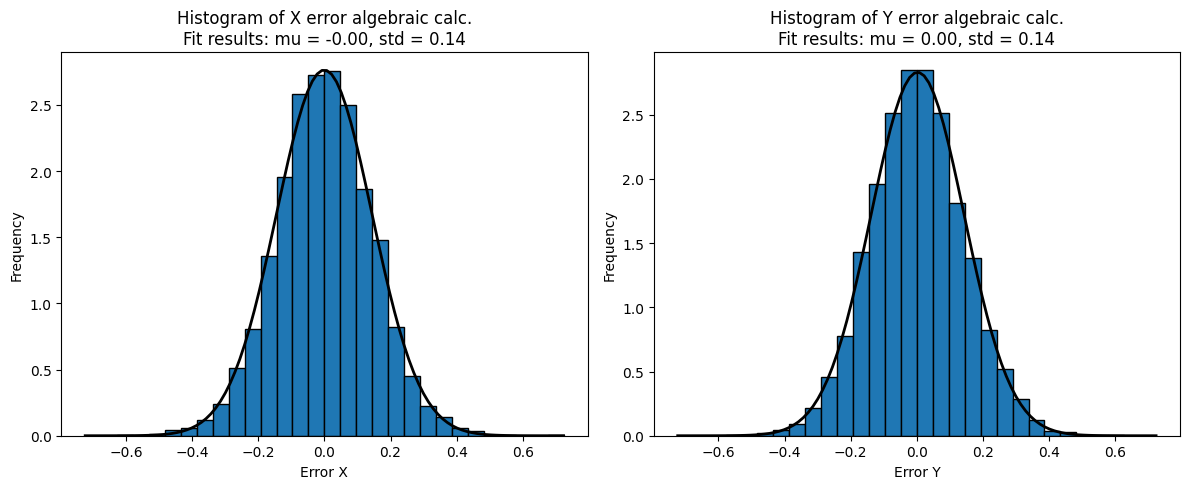

In [8]:
plot_error(out_pred, out_true, "algebraic calc.")

Neural network
Regression score:  0.9956997517624215
true: 
[[0.07391434 4.65202869]
 [0.81981004 4.76183214]
 [1.13614881 3.23270404]
 [3.27195778 0.94254568]]
predicted:
[[0.07838832 4.88480509]
 [0.82424165 4.96977529]
 [1.09281671 3.24412545]
 [3.24519053 0.74206499]]
Regression score:  0.9955854525824872


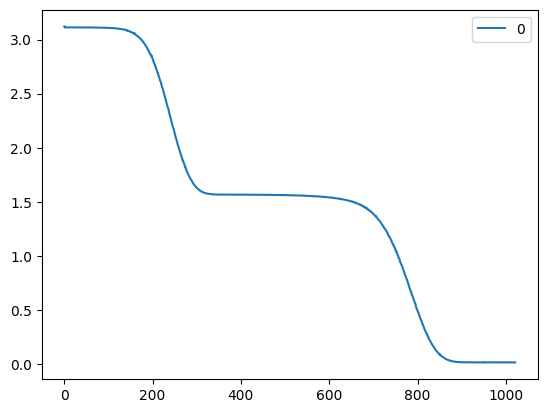

In [9]:

#Regression using neural network
print("Neural network")
regr = regression(out_meas, out_true)


# Plot the 'loss_curve_' protery on model to see how well we are learning over the iterations
pd.DataFrame(regr.loss_curve_).plot()

# save the model to disk
#filename = 'regr_model.sav'
#pickle.dump(regr, open(filename, 'wb'))

# load the model from disk
#regr = pickle.load(open(filename, 'rb'))

# Test regressor on the new data
#out_true, out_meas, rot_flag = monte_carlo_circle(radius, R_mic, time_error, num_points)
predicted = regr.predict(out_meas)

print("true: ")
print(out_true[0:4])
print("predicted:")
print(predicted[0:4])
print("Regression score: ",regr.score(out_meas, out_true))




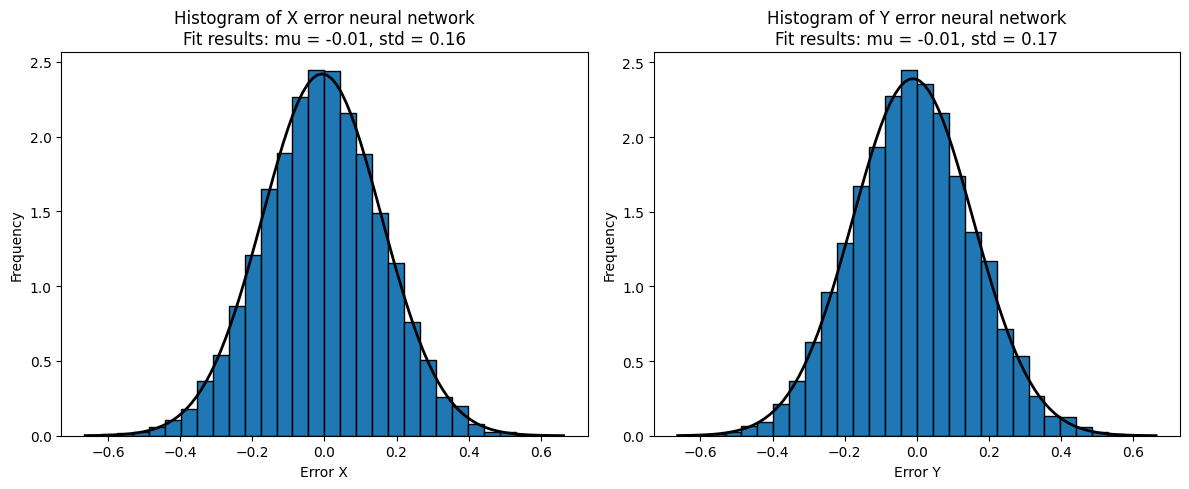

In [10]:
plot_error(predicted, out_true, "neural network")